In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    roc_curve
)
import joblib

### Testen op de testset

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
Gebruik threshold: 0.511
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

Evaluation with threshold=0.511
Accuracy:  0.831
Precision: 0.739
Recall:    0.810
F1-score:  0.773
ROC AUC:   0.936

Confusion Matrix:
TN: 32  FP: 6
FN: 4  TP: 17

Classification Report:
              precision    recall  f1-score   support

    Geen HVZ       0.89      0.84      0.86        38
         HVZ       0.74      0.81      0.77        21

    accuracy                           0.83        59
   macro avg       0.81      0.83      0.82        59
weighted avg       0.84      0.83      0.83        59



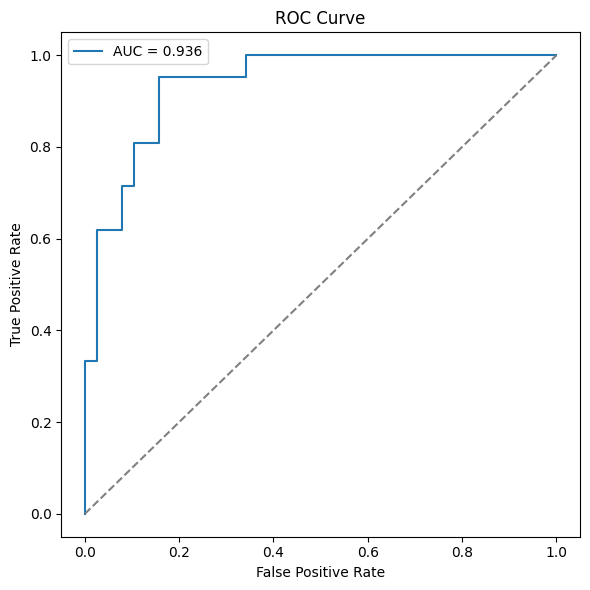

In [3]:
SEED = 42
np.random.seed(SEED)

X_test_scaled = pd.read_pickle('X_ontest_scaled.pkl').values
y_test        = pd.read_pickle('y_ontest.pkl').values

model         = load_model('model5nnn.keras', compile=False)
opt_threshold = joblib.load('final_onn_threshold.pkl')

print(f"Gebruik threshold: {opt_threshold:.3f}")

probs = model.predict(X_test_scaled).ravel()

y_pred_opt = (probs >= opt_threshold).astype(int)

acc    = accuracy_score(y_test, y_pred_opt)
prec   = precision_score(y_test, y_pred_opt, zero_division=0)
rec    = recall_score(y_test, y_pred_opt)
f1     = f1_score(y_test, y_pred_opt)
auc    = roc_auc_score(y_test, probs)
cm     = confusion_matrix(y_test, y_pred_opt)
report = classification_report(
    y_test, y_pred_opt,
    target_names=['Geen HVZ','HVZ']
)

print(f"\nEvaluation with threshold={opt_threshold:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}")

print("\nConfusion Matrix:")
print(f"TN: {cm[0,0]}  FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}  TP: {cm[1,1]}")

print("\nClassification Report:")
print(report)

fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

### Testen op 1 deelnemer

In [4]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

model_nn      = load_model('model5nn.keras', compile=False)
opt_threshold = joblib.load('final_nn_threshold.pkl')
scaler        = joblib.load('standard_scaler.pkl')

X_test_scaled = pd.read_pickle('X_ntest_scaled.pkl')
y_test        = pd.read_pickle('y_ntest.pkl')

idx      = 0
x_single = X_test_scaled.iloc[[idx]].values  # array van shape (1, n_features)
y_true   = y_test.iloc[idx]

proba    = model_nn.predict(x_single).ravel()[0]
y_pred   = int(proba >= opt_threshold)

print(f"True label: {y_true}")
print(f"Predicted probability: {proba:.3f}")
print(f"Predicted class (threshold={opt_threshold:.3f}): {y_pred}")

sample_raw = {
    'age': 58,
    'sex': 1,
    'cp': 4,
    'trestbps': 130,
    'chol': 245,
    'fbs': 0,
    'restecg': 1,
    'thalach': 150,
    'exang': 0,
    'oldpeak': 2.3
}
df_sample = pd.DataFrame([sample_raw])

# 3) Schalen met je opgeslagen scaler
x_scaled = scaler.transform(df_sample)

# 4) Voorspellen
proba2  = model_nn.predict(x_scaled).ravel()[0]
y_pred2 = int(proba2 >= opt_threshold)

print("\nNieuw record:")
print(sample_raw)
print(f"Predicted probability: {proba2:.3f}")
print(f"Predicted class (threshold={opt_threshold:.3f}): {y_pred2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
True label: 0
Predicted probability: 0.328
Predicted class (threshold=0.511): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Nieuw record:
{'age': 58, 'sex': 1, 'cp': 4, 'trestbps': 130, 'chol': 245, 'fbs': 0, 'restecg': 1, 'thalach': 150, 'exang': 0, 'oldpeak': 2.3}
Predicted probability: 0.792
Predicted class (threshold=0.511): 1


> Output

Optie A (test‑rij 0):
- True label: 0 → deze patiënt heeft in werkelijkheid geen hart‑/vaatziekte
- Predicted probability: 0.328 → het model schat de kans op HVZ op 32,8 %
- Predicted class (threshold=0.484): 0 → omdat 0.328 < 0.484, valt dit onder de cutoff, en het model voorspelt “geen hartziekte”

Conclusie: het model geeft een lage kansscore en classificeert deze patiënt correct als gezond.

Optie B (nieuw record):
- Samplegegevens: leeftijd 58, man, asymptomatische pijn (cp 4), rust‑bloeddruk 130, cholesterol 245, nuchter bloedsuiker normaal, rust‑ECG afwijking, max hartslag 150, geen inspanningsangina, oldpeak 2.3
- Predicted probability: 0.792 → het model schat de kans op HVZ op 79,2 %
- Predicted class (threshold=0.484): 1 → omdat 0.792 ≥ 0.484, voorspelt hij “wel hartziekte”
- Conclusie: voor dit nieuwe patiëntprofiel geeft het model een hoge kansscore en klassificeert het terecht als mogelijk ziek—wat overeenkomt met de klinische signalen van asymptomatische afwijkingen en verhoogd cholesterol.